In [1]:
from analysis.analyze_results import *
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from collections import defaultdict

In [2]:
def extract_timelines(output_base_folder: Path, folder_filter: str = "**", filter_by_metadata: Dict[str, List[str]] = None,
):
    files = list(output_base_folder.rglob(f"{folder_filter}/timeline-*.log"))
    data = []
    for working_file_path in tqdm.tqdm(files, total=len(files)):
        results = parse_results_log(working_file_path)
        if len(results) == 0:
            continue
        results = pd.DataFrame.from_records(data=results)
        results = pd.merge(results[results["end_time"].isnull()], 
                           results[results["start_time"].isnull()], 
                           left_on='id', 
                           right_on='id').drop(['end_time_x', 'start_time_y'], axis=1)
        results["source_file"] = working_file_path
        results["run"] = working_file_path.parent.name
        # filter out old data format missing dataset etc.
        data.append(results)
    df = pd.concat(data)
    df.groupby
    return df

In [30]:
def get_gpu_stats(df, gpu_util, run, flat=False, show_gpu=False, zoom=False, zoom_epochs = 1):
    data = defaultdict(list)
    start = min(df["start_time_x"]) 
    end = max(df["end_time_y"]) 
    gpu_start = min(gpu_util["timestamp"])
    gpu_end = max(gpu_util["timestamp"])
    
    total_runtime = (end - start)
    filename = run.split('_')
    gpu_util_mean = 0
    gpu_util_mean_no_zeros = 0
    
    gpu_events = []
    for i in gpu_util["timestamp"]:
        gpu_events.append(i - start)
    gpu_util_zeros = (len(gpu_util[gpu_util['gpu_util_2'] == 0]['gpu_util_2']) / len(gpu_util['gpu_util_2'])) * 100        
    gpu_util_mean_no_zeros = np.mean(gpu_util[gpu_util['gpu_util_2'] > 0]['gpu_util_2']) 
    mem_util_mean = np.mean(gpu_util['mem_util_2'])
    mem_util_mean_no_zeros = np.mean(gpu_util[gpu_util['mem_util_2'] > 0]['mem_util_2']) 
#     print(gpu_util_mean_no_zeros, mem_util_mean_no_zeros)

    return {"runtime": end-start, 
            "gpu_util_zero": gpu_util_zeros, 
            "gpu_util_mean_no_zeros": gpu_util_mean_no_zeros, 
            "mem_util_mean": mem_util_mean, 
            "mem_util_mean_no_zeros": mem_util_mean_no_zeros, 
            "implementation": filename[9],
            "cache": filename[8],
            "library": filename[3]
           }

In [14]:
def extract_gpuutil(output_base_folder: Path, folder_filter: str = "**", filter_by_metadata: Dict[str, List[str]] = None,
):
    files = list(output_base_folder.rglob(f"{folder_filter}/gpuutil-*.log"))
    data = []
    for working_file_path in tqdm.tqdm(files, total=len(files)):
        results = parse_results_log(working_file_path)
        if len(results) == 0:
            continue
        header = []
        header.append("timestamp")
        for i in results[0]["gpu_data"]:
            header.append(f"gpu_util_{i}")
            header.append(f"mem_util_{i}")
        header.append("run")
        lines = []
        for result in results:
            line = []
            line.append(result["timestamp"])
            for item in result["gpu_data"]:
                line.append(result["gpu_data"][item]["gpu_util"])
                line.append(result["gpu_data"][item]["mem_util"])
            line.append(working_file_path.parent.name)
            lines.append(line)
        results = pd.DataFrame.from_records(lines)
        data.append(results)
    df = pd.concat(data)
    df.columns = header
    df.groupby
    df.sort_values(["timestamp"], ascending=True)
    return df

In [500]:
# setup folders
base_folder = "repeated-runs-0212/0102_run_"
results_scratch = []
results_s3 = []
for folder_index in range(1, 11):
    print(f"Working with {folder_index}")
    output_base_folder = Path("/iarai/home/ivan.svogor/git/storage-benchmarking/src/benchmark_output")
    s3_folder_filter= base_folder + str(folder_index) + "/s3/*benchmark_e2e*"
    scratch_folder_filter= base_folder + str(folder_index) + "/scratch/*benchmark_e2e*"

    # read data
    df_dataloader_s3 = extract_timelines(output_base_folder, folder_filter=s3_folder_filter)
    df_dataloader_scratch = extract_timelines(output_base_folder, folder_filter=scratch_folder_filter)

    # Get unique functions 
    unique_functions_scratch = np.unique(df_dataloader_scratch["item_x"])
    print(f"Unique functions: {unique_functions_scratch}")
    
    unique_runs_scratch = np.unique(df_dataloader_scratch["run"])
    unique_runs_s3 = np.unique(df_dataloader_s3["run"])

    # extract GPU UTIL
    df_gpuutil_scratch = extract_gpuutil(output_base_folder, folder_filter=scratch_folder_filter)
    unique_runs_scratch = np.unique(df_dataloader_scratch["run"])
    
    df_gpuutil_s3 = extract_gpuutil(output_base_folder, folder_filter=s3_folder_filter)
    unique_runs_s3 = np.unique(df_dataloader_s3["run"])


    # dataset size
    samples = 15000

    # Get data for scratch

    returns_scratch = []
    for run in sorted(unique_runs_scratch):
        df = df_dataloader_scratch[df_dataloader_scratch["run"]==run]
        dfgpu = df_gpuutil_scratch[df_gpuutil_scratch["run"]==run]
        returns_scratch.append(get_gpu_stats(df, dfgpu, run, False, True, False, 2))
    result = pd.DataFrame.from_records(data=returns_scratch)
    result["throughput"] = samples / result["runtime"]
    results_scratch.append(result)
    
    returns_s3 = []
    for run in sorted(unique_runs_s3):
        df = df_dataloader_s3[df_dataloader_s3["run"]==run]
        dfgpu = df_gpuutil_s3[df_gpuutil_s3["run"]==run]
        returns_s3.append(get_gpu_stats(df, dfgpu, run, False, True, False, 2))
    result = pd.DataFrame.from_records(data=returns_s3)
    result["throughput"] = samples / result["runtime"]
    results_s3.append(result)

Working with 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:07<00:00, 28.29it/s]


Unique functions: ['batch' 'next_data' 'run_training_batch' 'training_batch_to_device']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:08<00:00, 25.68it/s]


Working with 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:06<00:00, 32.41it/s]


Unique functions: ['batch' 'next_data' 'run_training_batch' 'training_batch_to_device']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:07<00:00, 28.28it/s]


Working with 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:06<00:00, 35.87it/s]


Unique functions: ['batch' 'next_data' 'run_training_batch' 'training_batch_to_device']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:07<00:00, 29.14it/s]


Working with 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:07<00:00, 28.79it/s]


Unique functions: ['batch' 'next_data' 'run_training_batch' 'training_batch_to_device']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:06<00:00, 32.21it/s]


Working with 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:06<00:00, 35.66it/s]


Unique functions: ['batch' 'next_data' 'run_training_batch' 'training_batch_to_device']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:22<00:00,  9.57it/s]


Working with 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:14<00:00, 15.25it/s]


Unique functions: ['batch' 'next_data' 'run_training_batch' 'training_batch_to_device']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:11<00:00, 18.87it/s]


Working with 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:15<00:00, 13.51it/s]


Unique functions: ['batch' 'next_data' 'run_training_batch' 'training_batch_to_device']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:06<00:00, 30.88it/s]


Working with 8


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 269.70it/s]


Unique functions: ['batch' 'next_data' 'run_training_batch' 'training_batch_to_device']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:05<00:00, 36.26it/s]


Working with 9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 228.42it/s]


Unique functions: ['batch' 'next_data' 'run_training_batch' 'training_batch_to_device']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:06<00:00, 35.29it/s]


Working with 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:11<00:00, 18.38it/s]


Unique functions: ['batch' 'next_data' 'run_training_batch' 'training_batch_to_device']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:12<00:00, 17.47it/s]


In [501]:
len(results_s3), len(results_scratch), 

(10, 10)

In [502]:
print(len(results_s3))
print(len(results_scratch))

10
10


In [503]:
impls = ["threaded", "asyncio", "vanilla"]
libs = ["torch", "lightning"]

def plot_histogram(throughput, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.rcParams.update({'font.size': 12})
    ax.hist(throughput, bins=3)
    mean = np.mean(throughput).round(2)
    std = np.std(throughput).round(2)
    ax.axvline(np.mean(throughput), linestyle='dashed', linewidth=2, color="green")
    ax.set_title(title + f": mean = {mean},"
                 f" var: {np.var(throughput).round(2)},"
                 f" std:{std}")
    ax.set_xlabel("Throughput (imgs/S)", loc="right")
    ax.set_ylabel("Experiments", loc="center")
    ax.set_xlim(mean - 3*std, mean + 3*std)
    ax.plot()
    
def plot_all(res):
    df_throughput_all = pd.DataFrame()
    for impl in impls:
        for lib in libs:
            throughput = []
            key = f"{impl}_{lib}"
            for experiment in range(len(res)):
                data = res[experiment].round(2)
                data = data[(data["library"]==lib) & (data["implementation"]==impl)]["throughput"]
                throughput.append(data)
            df_throughput_all[key] = pd.DataFrame.from_records(throughput)
            plot_histogram(throughput, f"Setup: {impl}, {lib}")
    return df_throughput_all

S3


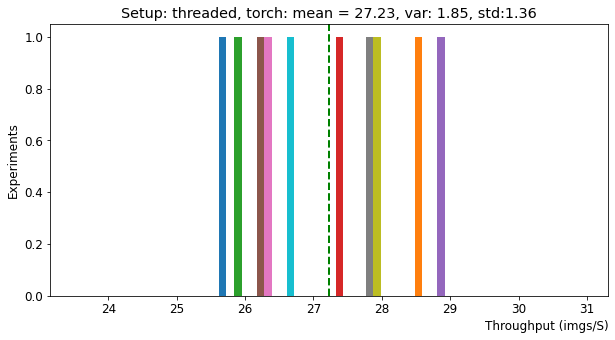

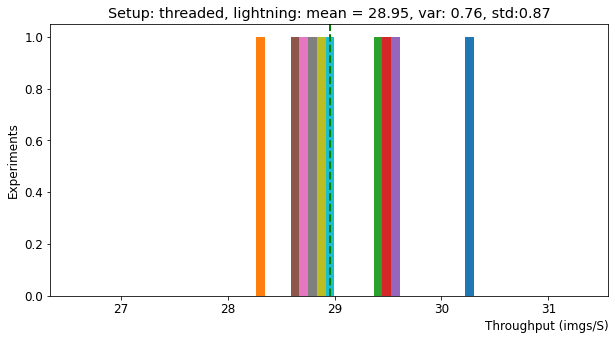

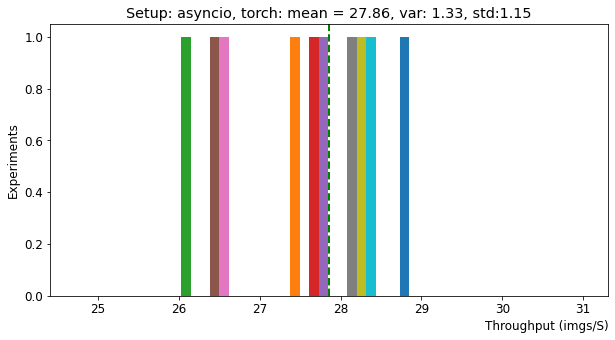

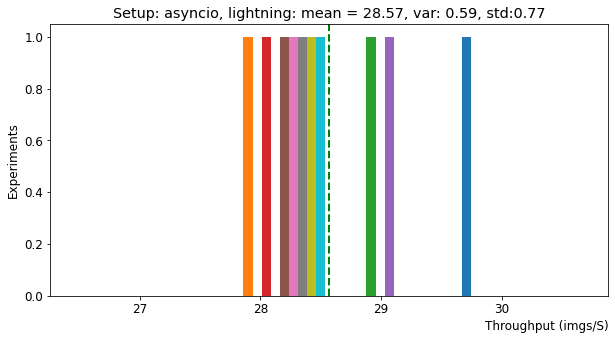

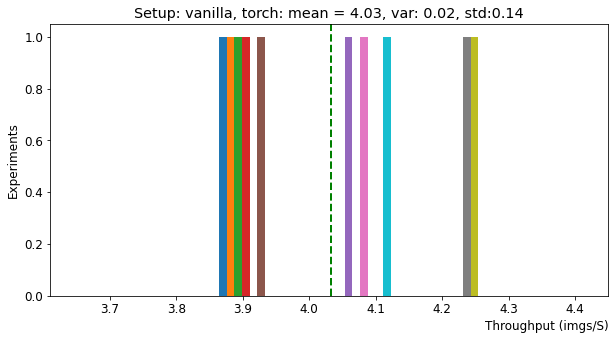

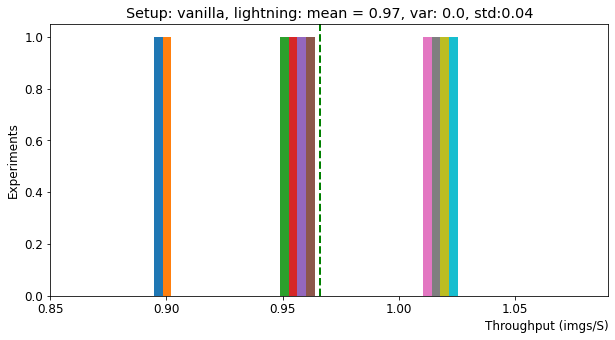

In [504]:
print("S3")
throughput_all_s3 = plot_all(results_s3)

Scratch


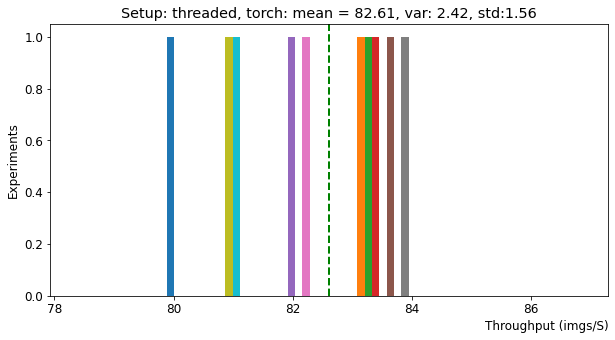

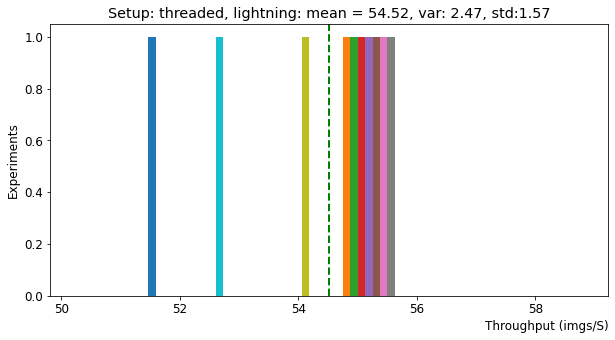

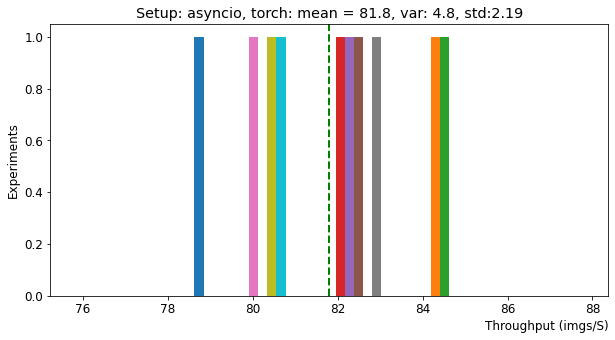

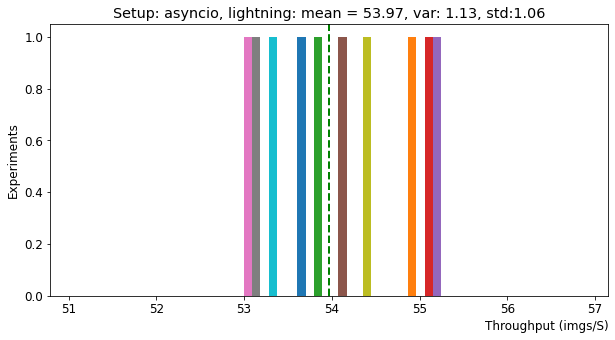

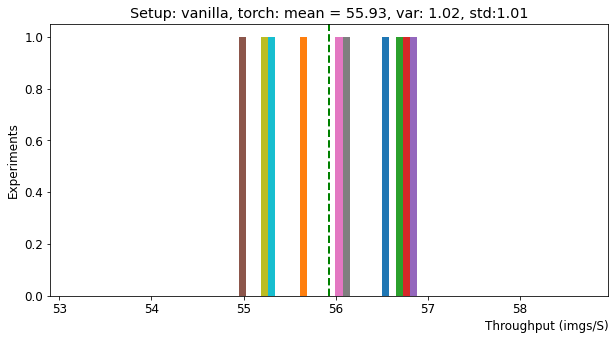

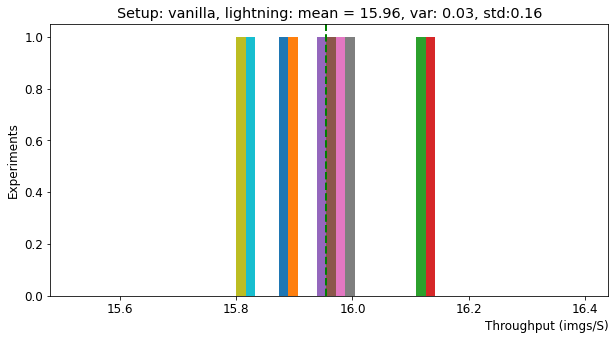

In [505]:
print("Scratch")
throughput_all_scratch = plot_all(results_scratch)

In [515]:
df_t_s3 = throughput_all_s3.T
mean = df_t_s3.mean(axis=1)
var = df_t_s3.var(axis=1)
std = df_t_s3.std(axis=1)
df_t_s3["mean"] = mean.round(2)
df_t_s3["var"] = var.round(2)
df_t_s3["std"] = std.round(2)

In [516]:
df_t_s3

,0,1,2,3,4,5,6,7,8,9,mean,var,std
threaded_torch,25.48,29.45,26.36,27.06,29.61,25.91,26.31,28.07,27.63,26.45,27.23,2.06,1.43
threaded_lightning,31.14,28.14,29.40,29.14,29.39,28.10,28.53,28.90,28.71,28.08,28.95,0.84,0.92
asyncio_torch,30.05,28.56,25.65,27.75,28.58,26.94,27.10,28.30,28.54,27.13,27.86,1.48,1.22
asyncio_lightning,30.52,28.32,29.06,28.32,29.03,27.97,28.06,28.39,28.32,27.69,28.57,0.65,0.81
vanilla_torch,3.85,3.98,3.90,3.99,4.04,3.86,4.12,4.28,4.18,4.12,4.03,0.02,0.14
vanilla_lightning,0.89,0.90,0.94,0.97,0.96,0.98,1.00,1.03,1.00,0.99,0.97,0.00,0.04


In [517]:
df_t_scratch = throughput_all_scratch.T
mean = df_t_scratch.mean(axis=1)
var = df_t_scratch.var(axis=1)
std = df_t_scratch.std(axis=1)
df_t_scratch["mean"] = mean.round(2)
df_t_scratch["var"] = var.round(2)
df_t_scratch["std"] = std.round(2)

In [518]:
df_t_scratch

,0,1,2,3,4,5,6,7,8,9,mean,var,std
threaded_torch,79.73,84.11,83.93,83.36,82.64,84.34,82.76,83.69,80.38,81.13,82.61,2.69,1.64
threaded_lightning,51.31,56.04,55.27,55.05,55.98,55.55,55.23,55.34,53.03,52.37,54.52,2.74,1.66
asyncio_torch,80.22,86.40,84.23,81.20,82.65,82.76,80.92,81.38,79.90,78.36,81.80,5.33,2.31
asyncio_lightning,53.74,55.26,53.92,54.73,55.83,54.12,52.88,52.73,54.14,52.32,53.97,1.25,1.12
vanilla_torch,57.03,55.45,57.37,57.23,56.51,54.57,55.93,55.48,55.24,54.47,55.93,1.13,1.06
vanilla_lightning,16.03,16.04,16.26,16.14,15.87,15.91,15.95,15.87,15.83,15.65,15.96,0.03,0.17


In [510]:
# def plot_violin(data, title):
# #     print(data)
#     fig, ax = plt.subplots(figsize=(10, 5))
#     plt.rcParams.update({'font.size': 12})
#     plt.violinplot(data, vert=False, widths=0.5, showmeans=True)

# for i in range(len(df_t_scratch)):
#     data = df_t_scratch.iloc[i].values.tolist()
#     plot_violin(data[:-3], data[0])

In [511]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

In [512]:
def plot_violins(throughput, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.rcParams.update({'font.size': 12})
    all_data = []
    labels = []
    for i in range(len(throughput)):
        data = throughput.iloc[i]
        index = data.name
        data = data.values.tolist()
        all_data.append(data[:-3])
        labels.append(index)
    # print(labels)
    ax.violinplot(all_data, vert=True, widths=0.5, showmeans=True)

    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels=labels, rotation=20)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Experiment setup')
    ax.set_ylabel('Throughput (imgs/s)')
    ax.set_title(title)
    # ax.set_xticks(range(len(labels)), labels=labels)
    ax.grid(linestyle='--', which="both")
    plt.plot()

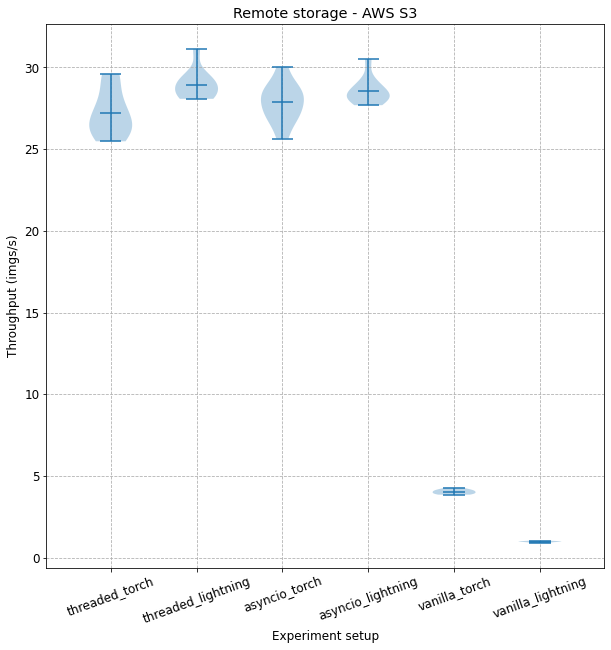

In [513]:
plot_violins(df_t_s3, "Remote storage - AWS S3")

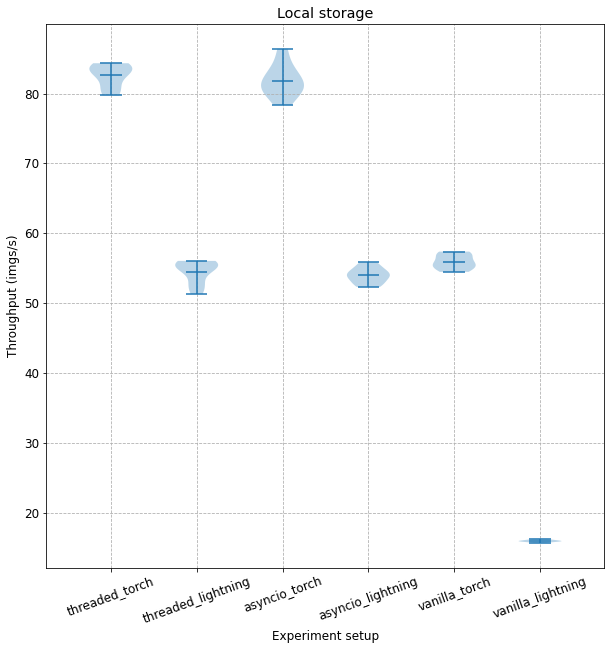

In [514]:
plot_violins(df_t_scratch, "Local storage")